In [1]:
# import required libs
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import roots_hermite

In [65]:
# Almgren-Chriss market simulator
class AC_simulator:
    '''
        the AC_simulator is Almgren-Chriss model 
        that implements price dynamics due to trader action (buy/sell market order)
        folowing the eq : dS = -k * v * dt + sigma * S0 * sqrt(dt) * dW,
        k - temp impact coeff, v - trading rate (shares / dt)
        Env attrs: state - Stock price S, reward - revenue for market order
        params: env_sigma, env_kappa, env_eta - note that params are not
        available to agent!
    '''
    # we assume that initially timestep (dt) is constant and predetermined 
    def __init__(self, S0, execution_time, dt, env_sigma, env_kappa, env_eta):
        self.is_frozen = False
        self.price_S0  = S0
        self.price_S   = S0
        self.exec_time = execution_time
        self.dt        = dt
        self.sqrt_dt   = np.sqrt(dt)
        self.env_sigma = env_sigma
        self.env_kappa = env_kappa
        self.env_eta   = env_eta
        
    def reset(self):
        self.price_S   = self.price_S0
        self.is_frozen = False
        return self.price_S
        
    # freeze time to prevent price change while agent exploration
    def freeze_time(self):
        self.is_frozen = True
        return
        
    def unfreeze_time(self):
        self.is_frozen = False
        return 
        
    def step(self, order: int):
        # order < 0 means we sell
        trading_rate = order / self.dt
        revenue = -trading_rate * (self.price_S + self.env_eta * trading_rate) * self.dt
        if self.is_frozen:
            return self.price_S, revenue
        else:
            self.price_S += self.env_kappa * trading_rate * self.dt + self.price_S0 * np.random.normal(loc=0, scale=self.sqrt_dt * self.env_sigma) 
            return self.price_S, revenue

        
# AC agent
class AC_agent:
    '''
        the agent decides what size of market order to execute
        according to Almgren-Chriss model optimal execution
        risk_aversion_lambda is a measure how the agent prefers to act:
        sell instantaneously (lambda ~0) or sell uniformly in time horizon (lambda >> 0)
        dzeta is a measure of willingness to explore (consider as standard deviation in random choosing (acc. Gauss))
        phi : policy parametrization vector
        psy : kappa, eta, sigma approximation vector
        theta: value-function parametrization vector
    '''
    def __init__(self,
                 risk_aversion_lambda: float, 
                 dzeta: float,
                 phi: np.ndarray, 
                 psy: np.ndarray,
                 theta: np.ndarray
                ):
        self.ra_lambda = risk_aversion_lambda
        self.dzeta     = dzeta
        self.phi       = phi
        self.psy       = psy
        self.M_phi     = np.eye(3)
        self.M_phi_inv = np.eye(3)
        self.theta     = theta
        self.theta_t   = np.zeros(3)
        
    def get_mu(self, inventory, expiry_time):
        return -inventory * self.phi[0] / np.tanh( self.phi[0] * expiry_time )
    def get_sigma(self):
        return self.dzeta * self.phi[1]
        
    def get_action(self, 
                   inventory, 
                   expiry_time):
        action = np.random.normal(
                    loc= self.get_mu(inventory, expiry_time),
                    scale=self.get_sigma())
        return action
    
    # update matrixes independently since we have to control the update order!
    def update_M_phi(self, price_S0):
        self.M_phi[1,1], self.M_phi[2,1] = self.phi[0], self.phi[0]
        self.M_phi[1,2], self.M_phi[2,2] = self.ra_lambda * price_S0 ** 2 / self.phi[0], -self.ra_lambda * price_S0 ** 2 / self.phi[0]
    
    def update_M_phi_inv(self, price_S0):
        self.M_phi_inv[1,1], self.M_phi_inv[1,2] = 1 / 2 / self.phi[0], 1 / 2 / self.phi[0]
        self.M_phi_inv[2,1], self.M_phi_inv[2,2] = self.phi[0] / 2 / self.ra_lambda / price_S0 ** 2, -self.phi[0] / 2 / self.ra_lambda / price_S0 ** 2
        
    def update_psy(self):
        self.psy = np.dot(self.M_phi_inv, self.theta_t)
        
    def g_function(self, trade_horizon):
        f_term = 1 / np.tanh(self.phi[0] * trade_horizon) / self.phi[0]
        s_term = trade_horizon / np.sinh(self.phi[0] * trade_horizon) ** 2
        t_term = -2 * self.phi[0] * trade_horizon ** 2 / np.sinh(self.phi[0] * trade_horizon) ** 2\
                    / np.tanh(self.phi[0] * trade_horizon) 
        return f_term + s_term + t_term
    
    def value_function(self, expiry_time, inventory, price_S):
        f_term = inventory * price_S
        s_term = self.dzeta / 2 * ( np.log(2 * np.pi * np.exp(1) * self.dzeta * self.phi[1])\
                    - (self.theta[1] + self.theta[2]) * self.phi[1] / self.phi[0] ) * expiry_time
        t_term = -inventory ** 2 / 2 * ( self.theta[0] + self.theta[1] / np.tanh(self.phi[0] * expiry_time)\
                    + self.theta[2] * self.phi[0] * expiry_time / np.sinh(self.phi[0] * expiry_time) ** 2 )
        return f_term + s_term + t_term
    

def compare_to_true(phi, theta, env_sigma, env_kappa, env_eta, price_S0):
    '''
        compare calculated true value of phi vector (optimal parametrization) 
        and the agent phi vector (that we've got from learning algorithm)
    '''
    true_phi_1   = np.sqrt(risk_aversion_lambda * env_sigma**2 / env_eta)
    true_phi_2   = 1 / 2 / env_eta
    true_theta_1 = env_kappa
    true_theta_2 = true_phi_1 * env_eta + risk_aversion_lambda * price_S0**2 * env_sigma**2 / true_phi_1
    print(f'for chosen params: phi = {true_phi_1, true_phi_2}, theta = {true_theta_1, true_theta_2, 0}\n'\
         f'agent params: phi = {phi}, theta = {theta}')

In [113]:
# Exploratory Mean Quadratic Variance algorithm

from typing import Callable
class EMQV:
    
    def __init__(self, env: AC_simulator, agent: AC_agent):
        self.env   = env
        self.agent = agent
        
    def simulate(self, 
                 inventory_q0:      int,
                 N_trades:          int,
                 learning_epochs:   int,
                 learning_episodes: int,
                 explor_grid_nodes: int,
                 alpha_phi:         np.ndarray, 
                 alpha_t:           float,
                 ap_update_rule:    Callable[[float, int], float],
                 at_update_rule:    Callable[[float, int], float]
                ):
        
        # constants
        PI  = np.pi
        EXP = np.exp(1) 
        
        # params
        exec_time = env.exec_time
        dt        = env.dt
        
        # for Gauss-Hermite quadrature
        abscissas_y, weights_w = roots_hermite(explor_grid_nodes, mu=False)
        reward_vector          = np.zeros(explor_grid_nodes, dtype=float)
        
        for epoch in range(learning_epochs):
            theta_grad = np.zeros(3, dtype=float)
            
            for episode in range(learning_episodes):
                
                # drop to initial env state
                price_S              = self.env.reset()
                inventory_q          = inventory_q0
                price_trajectory     = np.zeros(N_trades + 1, dtype=float)
                inventory_trajectory = np.zeros(N_trades + 1, dtype=float)
                exploratory_reward   = np.zeros(N_trades, dtype=float)
                delta_P              = np.zeros(N_trades, dtype=float)
                
                # run execution !
                for time_step in range(N_trades):
                    # calculate mean and variance of policy ~ N(mu, sigma)
                    mu    = self.agent.get_mu(inventory_q, exec_time - dt * time_step)
                    sigma = self.agent.dzeta * agent.phi[1]
                    
                    # freeze time inside env to forbid price impact due trades exploration
                    self.env.freeze_time()
                    for j in range(explor_grid_nodes):
                        trading_rate_v = mu + np.sqrt(2) * sigma * abscissas_y[j]
                        _, reward_vector[j] = self.env.step( int(trading_rate_v * dt) ) # = order size inside
                    self.env.unfreeze_time()

                    # calculate exploratory reward
                    exploratory_reward[time_step] = np.round( np.dot(weights_w, reward_vector) / np.sqrt(PI) , 1 )

                    # execute the order
                    order = int( mu * dt )
                    next_price_S, revenue = self.env.step(order)

                    # calculate delta_P 
                    delta_P[time_step] = exploratory_reward[time_step] * dt + price_S * order + inventory_q * (next_price_S - price_S)
                    
                    # add price and inventory movements to trajectories 
                    price_trajectory[time_step]     = price_S 
                    inventory_trajectory[time_step] = inventory_q
                    # update inventory and price values 
                    inventory_q += order 
                    price_S      = next_price_S

                #print(f'exploratory reward = {exploratory_reward}')
                #print(f'delta_p = {delta_P}')
                
                # to set the last trajectories elems: current price, zero inventory
                price_trajectory[time_step + 1]     = price_S 
                inventory_trajectory[time_step + 1] = inventory_q # it may be <0 !

                #========== the end of execution episode ==========#
            
                #========== policy evaluation ==========#

                # drop to zero 3d-gradient for ML, Vi on each episode 
                d_theta_ML = np.zeros(3, dtype=float)
                d_theta_Vi = np.zeros((3, N_trades), dtype=float)
                #d_theta_Vi1 = np.zeros((3, N_trades), dtype=float)

                # calculate theta_gradient using (30,31,32,33)
                tis = np.arange(N_trades)
                d_theta_Vi[0] = - np.square(inventory_trajectory[:-1]) / 2
                d_theta_Vi[1] = d_theta_Vi[0] / np.tanh(self.agent.phi[0] * (exec_time - tis * dt))\
                    - self.agent.dzeta * self.agent.phi[1] / (2 * self.agent.phi[0]) * (exec_time - tis * dt)
                d_theta_Vi[2] = d_theta_Vi[0] * self.agent.phi[0] * (exec_time - tis * dt)\
                                        / np.sinh(self.agent.phi[0] * (exec_time - tis * dt)) ** 2\
                                        - dzeta * self.agent.phi[1] / (2 * self.agent.phi[0]) * (exec_time - tis * dt)
      
                for ti in range(N_trades):
                    # for each partial derivative add sum from j = ti to N-1
                    temp_part_term = np.sum(exploratory_reward[ti:] * dt - delta_P[ti:] * self.agent.ra_lambda)
                    #print(f'temp_term = {temp_part_term}\n')

                    for k in range(3):
                        d_theta_ML[k] += d_theta_Vi[k][ti]\
                        * (-self.agent.value_function(exec_time - ti * dt, inventory_trajectory[ti], price_trajectory[ti])\
                           + self.agent.dzeta * (exec_time - ti * dt) * np.log(np.sqrt(2 * PI * EXP * self.agent.dzeta * self.agent.phi[1]))\
                           + temp_part_term) * dt
                    #print(f'd_theta_ML = {d_theta_ML}')

                # according to (30) mult (-2) the d_theta_ML then add to total sum of theta_grad
                for k in range(3):
                    d_theta_ML[k] *= -2
                    theta_grad[k] += d_theta_ML[k]
                #print(f'theta_grad init = {theta_grad}')
                    
            #========== end of learning episodes ==========#
        
            # calculate theta gradient and update theta
            for k in range(3):
                digits = len( str( int(theta_grad[k]) ) ) + 3 + k
                theta_grad[k] = theta_grad[k] / learning_episodes / 10**digits  
                self.agent.theta_t[k] = self.agent.theta[k] - theta_grad[k] / alpha_t
            
            if epoch % 100 == 0:
                print(f'theta_grad = {theta_grad}')
                print(f'theta_t = {self.agent.theta_t}')

            #========== policy gradient ==========#

            # construct inv_M(Ф)_l
            self.agent.update_M_phi_inv(self.env.price_S0)

            # construct psy = inv_M * theta = [ kappa_imp, eta_imp, sigma**2_imp ]
            self.agent.psy = np.dot(self.agent.M_phi_inv, self.agent.theta_t)
            
            #print(f'kappa, eta, sigma**2 = {self.agent.psy}')

            # calc dphi_G
            # XXX: why we should average the grad if it doesn't depend on learning episode?
            d_phi1_G  = - inventory_q0 ** 2 * self.agent.theta[2] / 2 * self.agent.g_function(exec_time)
            d_phi2_G  = self.agent.dzeta * exec_time * ( 1 / 2 / self.agent.phi[1] - (self.agent.theta[1] + self.agent.theta[2]) / 2 / self.agent.phi[0] )
            digits    = len( str( int( d_phi1_G ) ) ) - 2
            d_phi1_G /= 10**digits
            
            if epoch % 100 == 0:
                print(f'alpha = {alpha_phi}')
                print(f'd_G grad = {[d_phi1_G / alpha_phi[0] / alpha_phi[0], d_phi2_G / alpha_phi[1]]}')

            # update phi
            self.agent.phi[0] += d_phi1_G / alpha_phi[0]
            self.agent.phi[1] += d_phi2_G / alpha_phi[1]
            
            if epoch % 100 == 0:
                print(f'new phi = {self.agent.phi}\n')

            #========== the end of policy gradient ==========#

            #========== recalibration ==========#

            # construct M(Ф)_l+1
            self.agent.update_M_phi(self.env.price_S0)

            # update theta
            self.agent.theta = np.dot(
                np.dot(self.agent.M_phi, self.agent.M_phi_inv), # = correction Identity matrix
                self.agent.theta_t )
            
            #========== the end of recalibration ==========#

            plt.plot(inventory_trajectory, label=f'epoch={epoch}')
            plt.title('inventory execution')

            alpha_t      *= at_update_rule(epoch)
            alpha_phi[0] *= ap_update_rule(epoch)
            alpha_phi[1] *= ap_update_rule(epoch)

        print(f'Learned agent with\nphi = {self.agent.phi},\ntheta={self.agent.theta}')

theta_grad = [5.27966502e-04 5.27966680e-05 2.78647005e-06]
theta_t = [-5.26966502e-04  9.94720333e-03 -2.68647005e-06]
alpha = [1. 1.]
d_G grad = [-2.4998655204034597, 0.005699997000000001]
new phi = [ 17.50013448 100.0057    ]

Learned agent with
phi = [ 86.79739233 100.28512176],
theta=[-0.01351706  0.02094317  0.01956999]
CPU times: total: 500 ms
Wall time: 517 ms


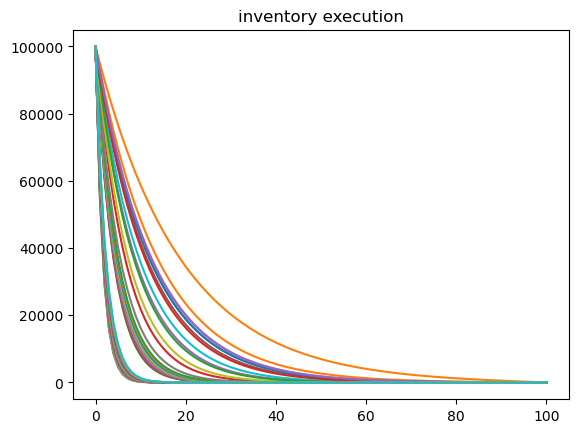

In [115]:
%%time

#-------------------------------------#
# Exploratory Mean Quadratic Variance
#-------------------------------------#

#-------------------------------------#
# ENVIRONMENT SET UP
#-------------------------------------#

# inventory params
price_S0 = 100
inventory_q0 = 100_000

# time parameters
execution_horizon = 100 # days
execution_time    = execution_horizon / 250 # there are 250 days per trading year
N_trades          = 100
dt                = execution_time / N_trades

# Env arbitrary params (have to be estimated from historical data)
env_sigma = 0.3
env_kappa = 2.5 * 1e-8
env_eta   = 2.5 * 1e-6

# create environment
env = AC_simulator(price_S0, execution_time, dt, env_sigma, env_kappa, env_eta)

#=====================================#

#-------------------------------------#
# AGENT SET UP
#-------------------------------------#

# agent arbitrary params, lambda depends on env_eta
risk_aversion_lambda = 0.001 #1e5 * env_eta
dzeta = 3
phi   = np.array([20, 100], dtype=float)
psy   = np.zeros(3, dtype=float)
theta = np.array([1e-6, 1e-2, 1e-7], dtype=float)

# create agent
agent = AC_agent(risk_aversion_lambda, dzeta, phi, psy, theta)

#=====================================#

#-------------------------------------#
# SIMULATION SET UP
#-------------------------------------#

# simulation params
learning_epochs   = 50
learning_episodes = 1
explor_grid_nodes = 10
alpha_phi = np.array([1, 1], dtype=float)
alpha_t   = 1
ap_update_rule = lambda i: 1.000001 ** i 
at_update_rule = lambda i: 1 #np.exp(0.000001 * i)

emqv = EMQV(env, agent)
emqv.simulate(inventory_q0, N_trades, learning_epochs,learning_episodes,
                 explor_grid_nodes, alpha_phi, alpha_t,
                 ap_update_rule, at_update_rule)

In [70]:
compare_to_true(agent.phi, agent.theta, env_sigma, env_kappa, env_eta, price_S0)

for chosen params: phi = (6.0, 200000.00000000003), theta = (2.5e-08, 0.15001499999999998, 0)
agent params: phi = [ 47.22566519 100.0570258 ], theta = [-0.00368359  0.01350054  0.00956727]
